In [1]:
import torch
import prettytable
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset
from torch.utils import data
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

In [2]:
#获取数据集
trans = [transforms.ToTensor()]
trans.insert(0, transforms.Resize(224))
trans = transforms.Compose(trans)
batch_size = 256

training_data = datasets.MNIST(
    root="./data",
    train=True,
    download=True,                                                                                                                                                                                              
    transform=trans
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=trans
)   

train_iter = data.DataLoader(training_data, batch_size, shuffle=True,
                        num_workers=2)
test_iter = data.DataLoader(test_data, batch_size, shuffle=False,
                        num_workers=2)

train_features, train_labels = next(iter(train_iter))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"batch size:{len(iter(train_iter))}")

Feature batch shape: torch.Size([256, 1, 224, 224])
Labels batch shape: torch.Size([256])
batch size:235


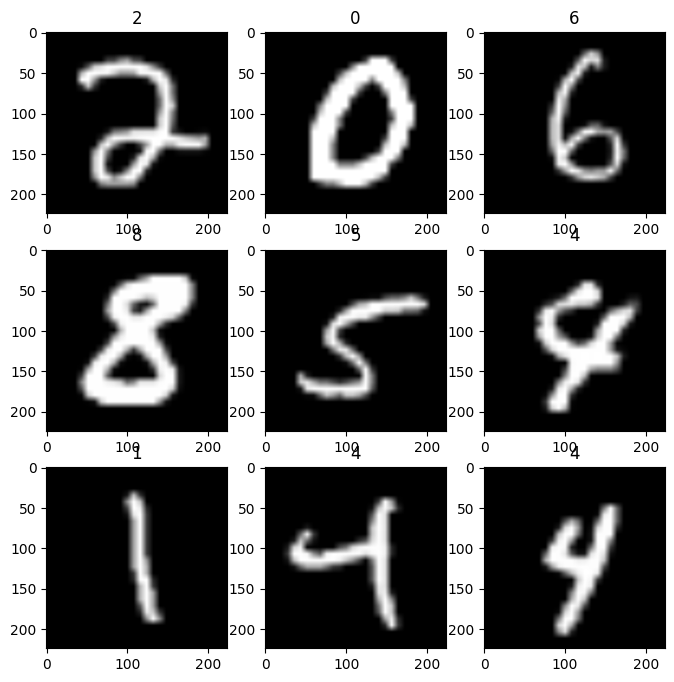

In [3]:
#随机展示训练集中的九张图片
figure = plt.figure(figsize=(8, 8))
sample_idx = torch.randint(len(training_data), size=(9,))
row, column = 0, 0
for i, pict_index in enumerate(sample_idx):
    img, label = training_data[pict_index]
    figure.add_subplot(3, 3, i+1)
    plt.title(str(label))
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
'''严格按照Alex Krizhevsky的论文“ImageNet Classification with Deep Convolutional Neural Networks"
定义AlexNet'''
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 96, kernel_size=(11, 11), stride=4, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=(5, 5), stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=(3, 3), padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(9216, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        out_conv1 = F.relu(self.conv1(x))
        out_pool1 = self.maxpool1(out_conv1)
        out_conv2 = F.relu(self.conv2(out_pool1))
        out_pool2 = self.maxpool2(out_conv2)
        out_conv3 = F.relu(self.conv3(out_pool2))
        out_conv4 = F.relu(self.conv4(out_conv3))
        out_conv5 = F.relu(self.conv5(out_conv4))
        out_pool3 = self.maxpool3(out_conv5)
        
        flatten_x = self.flatten(out_pool3)
        out_linear1 = F.relu(self.linear1(flatten_x))
        out_dropout1 = self.dropout1(out_linear1)
        out_linear2 = F.relu(self.linear2(out_dropout1))
        out_dropout2 = F.relu(out_linear2)
        out_linear3 = F.relu(self.linear3(out_dropout2))
        return out_linear3

In [5]:
model = AlexNet()
#获取网络各层输出的维度大小
for params in model.parameters():
    print(params.size())

torch.Size([96, 1, 11, 11])
torch.Size([96])
torch.Size([256, 96, 5, 5])
torch.Size([256])
torch.Size([384, 256, 3, 3])
torch.Size([384])
torch.Size([384, 384, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([4096, 9216])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([10, 4096])
torch.Size([10])


In [6]:
#查看网络的结构
model.to('cuda')
summary(model, input_size=(1, 224, 224), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
         MaxPool2d-2           [-1, 96, 27, 27]               0
            Conv2d-3          [-1, 256, 27, 27]         614,656
         MaxPool2d-4          [-1, 256, 13, 13]               0
            Conv2d-5          [-1, 384, 13, 13]         885,120
            Conv2d-6          [-1, 384, 13, 13]       1,327,488
            Conv2d-7          [-1, 256, 13, 13]         884,992
         MaxPool2d-8            [-1, 256, 6, 6]               0
           Flatten-9                 [-1, 9216]               0
           Linear-10                 [-1, 4096]      37,752,832
          Dropout-11                 [-1, 4096]               0
           Linear-12                 [-1, 4096]      16,781,312
           Linear-13                   [-1, 10]          40,970
Total params: 58,299,082
Trainable para

In [19]:
#定义超参数，采用SGD作为优化器
learning_rate = 0.001
batch_size = 256
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()
model.to(device)
loss_list = []
acc_list = []
epoch_num = []

def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

#定义训练循环和测试循环
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_list = []
    acc_list = []
    for t in range(epoch):
        print(f"Epoch {t+1}\n-------------------------------")
        running_loss = 0    
        loss, correct = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch % 50 == 49:
                writer.add_scalar('training loss',
                                running_loss / 50,
                                epoch * len(dataloader)+batch+1)
                
                loss, current = loss.item(), (batch+1) * len(X)
                loss_list.append(loss), epoch_num.append(t+current/size)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                running_loss = 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # loss /= num_batches
        # correct /= size
        # acc_list.append(correct)
        # loss_list.append(loss)
        
        test_loop(test_iter, model, loss_fn)

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    acc_list.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")


In [20]:
#开始训练(epoch=30)
model.apply(init_weights)
writer = SummaryWriter()
train_loop(train_iter, model, loss_fn, optimizer, 1)
print(range(len(loss_list)),loss_list)

Epoch 1
-------------------------------


KeyboardInterrupt: 

In [11]:
#保存模型
torch.save(model.state_dict(), 'MnistOnAlexNet_epoch30.pkl')

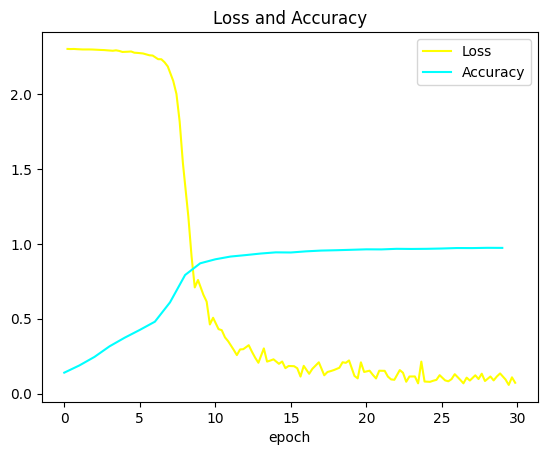

In [12]:
#绘制损失和准确度曲线
plt.title('Loss and Accuracy')
plt.xlabel('epoch')
plt.plot(epoch_num, loss_list, 'yellow')
plt.plot(range(30), acc_list, 'cyan')
plt.legend(['Loss', 'Accuracy'])
plt.show()

In [13]:
#评估模型
model.eval()
model.to('cpu')
pred_list = torch.tensor([])
with torch.no_grad():
    for X, y in test_iter:
        pred = model(X)
        pred_list = torch.cat([pred_list, pred])

In [14]:
test_iter1 = data.DataLoader(test_data, batch_size=10000, shuffle=False,
                        num_workers=2)
features, labels = next(iter(test_iter1))
print(labels.shape)

torch.Size([10000])


In [15]:
#输出每个类别的精确率和召回率
train_result = np.zeros((10, 10), dtype=int)
for i in range(len(test_data)):
    train_result[labels[i]][np.argmax(pred_list[i])] += 1
result_table = prettytable.PrettyTable()
result_table.field_names = ['Type', 'Accuracy(精确率)', 'Recall(召回率)', 'F1_Score']
class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
for i in range(10):
    accuracy = train_result[i][i] / train_result.sum(axis=0)[i]
    recall = train_result[i][i] / train_result.sum(axis=1)[i]
    result_table.add_row([class_names[i], np.round(accuracy, 3), np.round(recall, 3), 
                          np.round(accuracy * recall * 2 / (accuracy + recall), 3)])
print(result_table)

+-------+------------------+----------------+----------+
|  Type | Accuracy(精确率) | Recall(召回率) | F1_Score |
+-------+------------------+----------------+----------+
|  Zero |      0.975       |     0.993      |  0.984   |
|  One  |      0.992       |     0.985      |  0.989   |
|  Two  |      0.987       |     0.973      |   0.98   |
| Three |      0.956       |     0.984      |   0.97   |
|  Four |      0.989       |     0.969      |  0.979   |
|  Five |      0.985       |     0.972      |  0.979   |
|  Six  |       0.99       |     0.978      |  0.984   |
| Seven |      0.978       |     0.977      |  0.977   |
| Eight |      0.962       |     0.974      |  0.968   |
|  Nine |      0.961       |     0.967      |  0.964   |
+-------+------------------+----------------+----------+


In [16]:
#用softmax函数将最后一层的输出转化为(0,1)间的概率
pred_probilities = F.softmax(pred_list, dim=1)

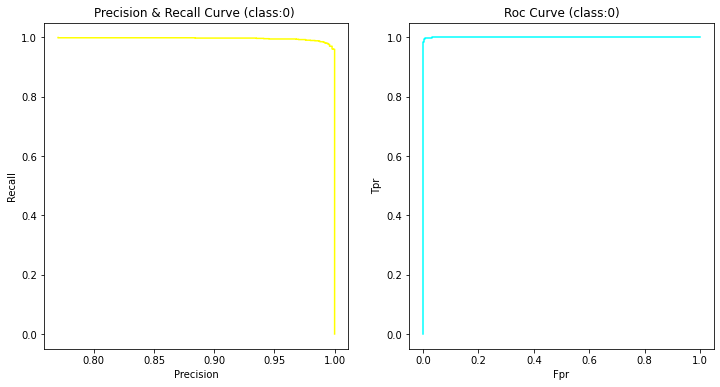

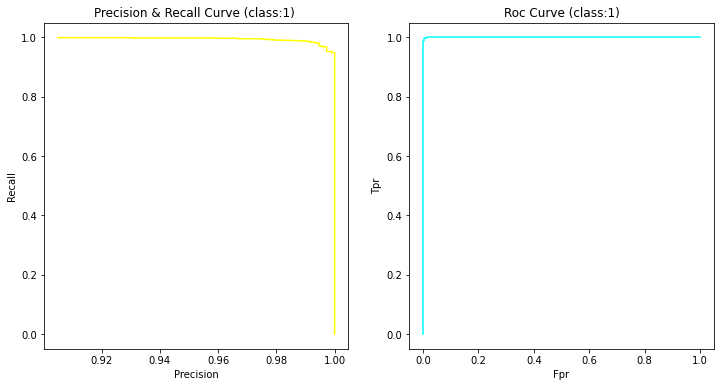

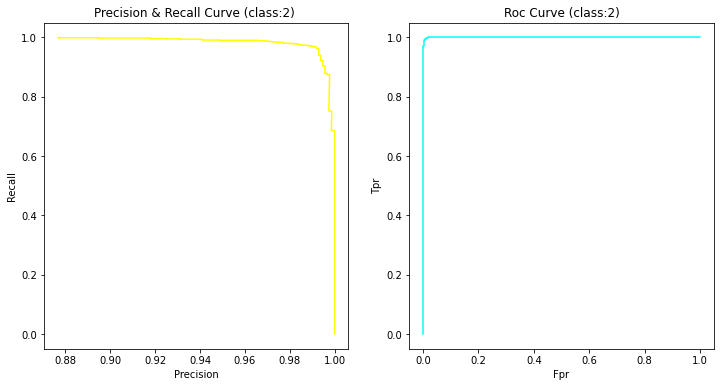

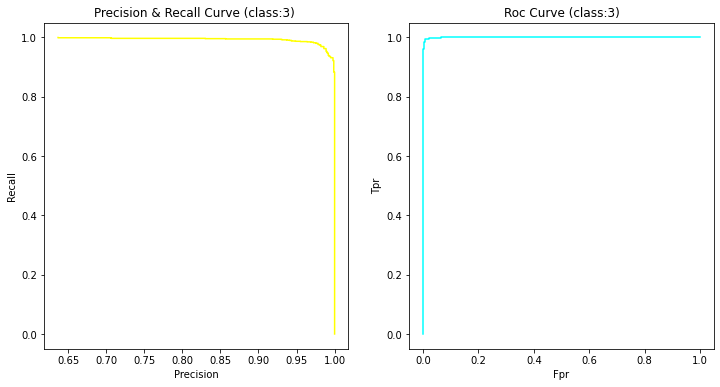

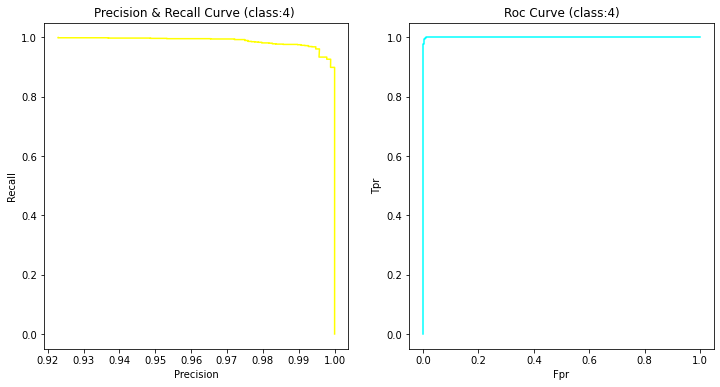

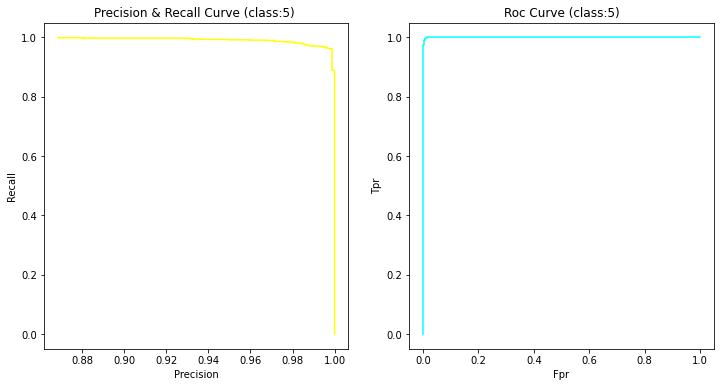

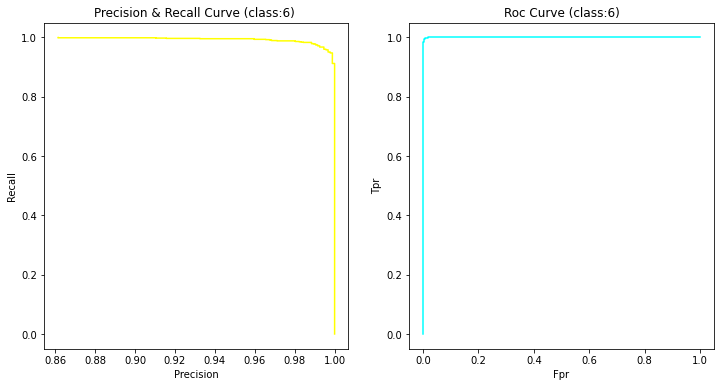

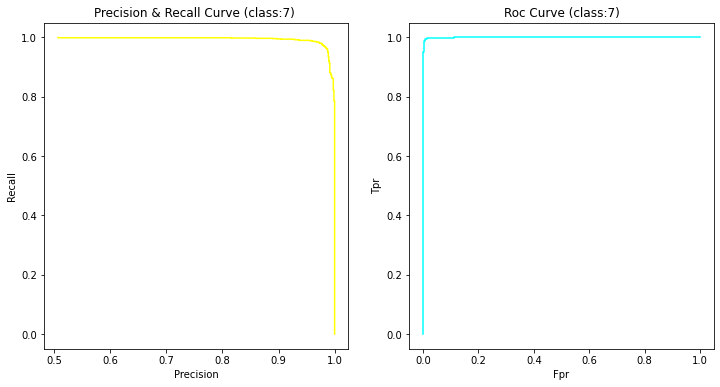

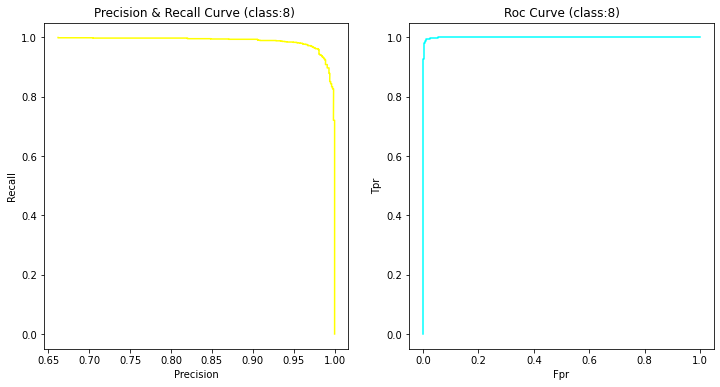

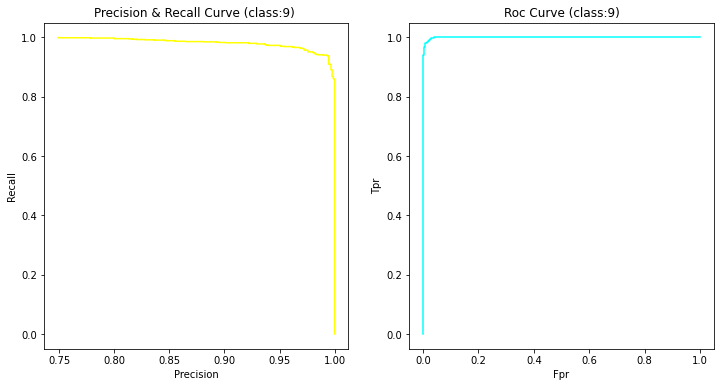

In [71]:
#采用scikit-learn模块对10个类分别绘制PR曲线和ROC曲线
from sklearn.metrics import precision_recall_curve, roc_curve

for i in range(10):
    temp_true = []
    temp_probilities = []
    temp = 0
    
    for j in range(len(labels)):
        if i == labels[j]:
            temp = 1
        else:
            temp = 0
        temp_true.append(temp)
        temp_probilities.append(pred_probilities[j][i])
        
    precision, recall, threshholds = precision_recall_curve(temp_true, temp_probilities)
    fpr, tpr, thresholds = roc_curve(temp_true, temp_probilities)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(f'Precision & Recall Curve (class:{i}) ')
    plt.plot(precision, recall, 'yellow')
    
    plt.subplot(1, 2, 2)
    plt.xlabel('Fpr')
    plt.ylabel('Tpr')
    plt.title(f'Roc Curve (class:{i})')
    plt.plot(fpr, tpr, 'cyan')
    plt.show()